# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_017  P61981                     15.273
Sample_162  Q8NBI6                     15.240
Sample_077  Q16610                     18.791
Sample_002  Q8TAB3;Q8TAB3-2;Q8TAB3-3   14.950
Sample_047  Q9NRN5                     17.744
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups               
Sample_122  D6RER2;D6RIH8;Q13634;Q13634-2   13.895
Sample_161  Q9UHI8                          14.054
Sample_005  Q9C0C4                          12.402
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.288
            A0A075B6Q5                 12.776
            A0A075B6R2                 13.299
            A0A075B6S5                 12.779
            A0A087WSY4                 13.030
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.555
            Q9UI40;Q9UI40-2            13.316
            Q9UIW2                     12.828
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.034
            Q9UP79                     13.221
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.597,15.050,16.842,19.863,13.350,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.814,19.067,...,15.528,15.576,12.030,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.662,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.178,17.705,17.039,13.980,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.982,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.504,15.345,17.084,18.708,14.249,19.433,7.358,8.919
Sample_207,15.739,16.877,15.469,16.898,10.908,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.288,...,16.012,15.178,12.847,15.050,16.842,19.863,12.588,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.955,19.067,16.188,...,15.528,15.576,12.683,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.371,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.910,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.066,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.149,15.345,17.084,18.708,14.249,19.433,12.932,12.773
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 366.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.64it/s]

100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.70it/s]

100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.71it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]

100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.68it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.39it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.45it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.74it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.53it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  2.45it/s]

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.14it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.57it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.52it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.53it/s]

100%|██████████| 8/8 [00:02<00:00,  2.57it/s]

100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.49it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.57it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.69it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.47it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.54it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.39it/s]

100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.67it/s]

 30%|███       | 3/10 [00:00<00:01,  4.61it/s]

 40%|████      | 4/10 [00:00<00:01,  4.19it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.85it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.69it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.64it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.53it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.42it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.03it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.97it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.61it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.58it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.48it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.51it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.42it/s]

100%|██████████| 11/11 [00:02<00:00,  3.51it/s]

100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.36it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.46it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.97it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.42it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.33it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.45it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.44it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.51it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.42it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.45it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.19it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.49it/s]

 31%|███       | 4/13 [00:00<00:02,  3.86it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.51it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.50it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.40it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.32it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.23it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.14it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.22it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.25it/s]

100%|██████████| 13/13 [00:03<00:00,  3.27it/s]

100%|██████████| 13/13 [00:03<00:00,  3.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.70it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.91it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.49it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.32it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.23it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.20it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.23it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.25it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.28it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.33it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.19it/s]

100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.05it/s]

 20%|██        | 3/15 [00:00<00:02,  4.35it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.90it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.47it/s]

 40%|████      | 6/15 [00:01<00:02,  3.38it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.36it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.21it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.18it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.29it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.28it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.33it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.27it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.26it/s]

100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.050 0.010          0.825 0.292       0.135   
2             0.004 0.002      0.052 0.012          0.664 0.099       0.535   
3             0.004 0.003      0.055 0.015          0.748 0.084       0.737   
4             0.004 0.002      0.051 0.009          0.763 0.085       0.762   
5             0.004 0.000      0.049 0.004          0.776 0.099       0.768   
6             0.005 0.003      0.063 0.022          0.771 0.107       0.769   
7             0.005 0.003      0.061 0.021          0.767 0.106       0.768   
8             0.005 0.007      0.049 0.014          0.796 0.094       0.786   
9             0.003 0.002      0.037 0.010          0.813 0.083       0.842   
10            0.004 0.000      0.040 0.006          0.812 0.082       0.843   
11            0.004 0.001      0.041 0.004          0.811 0.081       0.841   
12            0.004 0.000      0.047 0.002          0.811 0.087       0.839   
13            0.004 0.000      0.048 0.000          0.806 0.090       0.829   
14            0.004 0.001      0.048 0.001          0.803 0.093       0.821   
15            0.004 0.000      0.048 0.001          0.796 0.089       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.224 0.127                  0.560 0.042        0.860   
2          0.114   0.583 0.080                  0.664 0.053        0.737   
3          0.116   0.737 0.079                  0.776 0.064        0.854   
4          0.125   0.756 0.082                  0.793 0.066        0.857   
5          0.101   0.766 0.073                  0.799 0.061        0.878   
6          0.110   0.764 0.081                  0.797 0.067        0.877   
7          0.103   0.761 0.077                  0.795 0.065        0.875   
8          0.091   0.787 0.075                  0.818 0.063        0.896   
9          0.081   0.824 0.064                  0.849 0.056        0.918   
10         0.080   0.825 0.063                  0.849 0.055        0.917   
11         0.082   0.823 0.063                  0.847 0.055        0.916   
12         0.088   0.821 0.066                  0.846 0.057        0.914   
13         0.086   0.813 0.064                  0.839 0.056        0.912   
14         0.091   0.808 0.068                  0.834 0.059        0.911   
15         0.086   0.805 0.064                  0.832 0.056        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.827 0.087        210.000 0.000  
2          0.069                  0.663 0.090        210.000 0.000  
3          0.062                  0.822 0.079        210.000 0.000  
4          0.064                  0.823 0.081        210.000 0.000  
5          0.053                  0.846 0.073        210.000 0.000  
6          0.052                  0.847 0.072        210.000 0.000  
7          0.051                  0.846 0.070        210.000 0.000  
8          0.048                  0.881 0.057        210.000 0.000  
9          0.042                  0.905 0.048        210.000 0.000  
10         0.042                  0.904 0.048        210.000 0.000  
11         0.044                  0.903 0.050        210.000 0.000  
12         0.046                  0.899 0.054        210.000 0.000  
13         0.046                  0.897 0.053        210.000 0.000  
14         0.047                  0.896 0.053        210.000 0.000  
15         0.047                  0.896 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 482.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.26it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.82it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.77it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.23it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.26it/s]

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.30it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.20it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.63it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]

100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.24it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.49it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.14it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.04it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.75it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.23it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.56it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.04it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.89it/s]

100%|██████████| 9/9 [00:03<00:00,  1.87it/s]

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.82it/s]

 30%|███       | 3/10 [00:00<00:02,  3.24it/s]

 40%|████      | 4/10 [00:01<00:02,  2.42it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.10it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.93it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.06it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.16it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.54it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.97it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.12it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.99it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.76it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.19it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.97it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.87it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.01it/s]

100%|██████████| 11/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.48it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.43it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.31it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.31it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.40it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.55it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.54it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.57it/s]

100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

100%|██████████| 12/12 [00:04<00:00,  2.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.73it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.80it/s]

 31%|███       | 4/13 [00:01<00:03,  2.56it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.74it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.82it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.80it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.83it/s]

100%|██████████| 13/13 [00:04<00:00,  2.10it/s]

100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.71it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.08it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.18it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.17it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.08it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.77it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.26it/s]

 71%|███████▏  | 10/14 [00:03<00:02,  1.89it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.69it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.68it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.80it/s]

100%|██████████| 14/14 [00:06<00:00,  1.95it/s]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.49it/s]

 20%|██        | 3/15 [00:00<00:03,  3.89it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.73it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.45it/s]

 40%|████      | 6/15 [00:02<00:04,  2.07it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.86it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.75it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.72it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.83it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.01it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.02it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.05it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.04it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

100%|██████████| 15/15 [00:07<00:00,  2.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.049 0.004          0.854 0.241       0.154   
2             0.004 0.000      0.046 0.004          0.611 0.107       0.479   
3             0.004 0.000      0.044 0.003          0.818 0.079       0.723   
4             0.007 0.006      0.071 0.027          0.812 0.080       0.773   
5             0.005 0.004      0.064 0.023          0.804 0.080       0.758   
6             0.005 0.003      0.051 0.013          0.797 0.087       0.759   
7             0.005 0.003      0.075 0.036          0.816 0.092       0.790   
8             0.006 0.005      0.077 0.028          0.816 0.095       0.783   
9             0.005 0.004      0.058 0.017          0.807 0.079       0.847   
10            0.005 0.004      0.068 0.024          0.803 0.081       0.821   
11            0.005 0.003      0.054 0.019          0.809 0.078       0.823   
12            0.006 0.004      0.069 0.023          0.808 0.079       0.831   
13            0.007 0.006      0.074 0.033          0.809 0.080       0.827   
14            0.005 0.003      0.060 0.021          0.806 0.077       0.829   
15            0.005 0.004      0.053 0.013          0.788 0.073       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.252 0.125                  0.569 0.042        0.849   
2          0.120   0.528 0.096                  0.625 0.062        0.708   
3          0.106   0.762 0.072                  0.801 0.057        0.897   
4          0.107   0.787 0.072                  0.820 0.060        0.902   
5          0.115   0.775 0.078                  0.810 0.063        0.898   
6          0.107   0.772 0.076                  0.807 0.062        0.894   
7          0.102   0.798 0.074                  0.828 0.063        0.903   
8          0.105   0.794 0.077                  0.825 0.065        0.901   
9          0.100   0.823 0.070                  0.849 0.062        0.911   
10         0.088   0.808 0.065                  0.835 0.057        0.913   
11         0.093   0.812 0.066                  0.839 0.058        0.916   
12         0.092   0.815 0.061                  0.842 0.054        0.920   
13         0.088   0.813 0.058                  0.840 0.050        0.917   
14         0.087   0.813 0.057                  0.840 0.049        0.917   
15         0.087   0.801 0.057                  0.829 0.049        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.088        210.000 0.000  
2          0.077                  0.658 0.096        210.000 0.000  
3          0.048                  0.879 0.057        210.000 0.000  
4          0.048                  0.882 0.056        210.000 0.000  
5          0.052                  0.878 0.060        210.000 0.000  
6          0.053                  0.874 0.060        210.000 0.000  
7          0.054                  0.887 0.061        210.000 0.000  
8          0.054                  0.885 0.061        210.000 0.000  
9          0.050                  0.899 0.052        210.000 0.000  
10         0.045                  0.899 0.049        210.000 0.000  
11         0.046                  0.904 0.050        210.000 0.000  
12         0.043                  0.909 0.048        210.000 0.000  
13         0.043                  0.907 0.047        210.000 0.000  
14         0.043                  0.906 0.047        210.000 0.000  
15         0.042                  0.905 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 964.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 14.18it/s]

100%|██████████| 2/2 [00:00<00:00, 13.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.94it/s]

100%|██████████| 3/3 [00:00<00:00, 18.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.97it/s]

100%|██████████| 4/4 [00:00<00:00,  9.87it/s]

100%|██████████| 4/4 [00:00<00:00, 10.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.73it/s]

100%|██████████| 5/5 [00:00<00:00, 15.23it/s]

100%|██████████| 5/5 [00:00<00:00, 15.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.72it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.00it/s]

100%|██████████| 6/6 [00:00<00:00, 12.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.32it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.68it/s]

100%|██████████| 7/7 [00:00<00:00, 13.30it/s]

100%|██████████| 7/7 [00:00<00:00, 13.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 17.55it/s]

 50%|█████     | 4/8 [00:00<00:00, 10.70it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 10.45it/s]

100%|██████████| 8/8 [00:00<00:00,  9.56it/s]

100%|██████████| 8/8 [00:00<00:00, 10.12it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.54it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.30it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.89it/s]

100%|██████████| 9/9 [00:00<00:00, 12.47it/s]

100%|██████████| 9/9 [00:00<00:00, 12.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.14it/s]

 40%|████      | 4/10 [00:00<00:00, 12.89it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.45it/s]

 80%|████████  | 8/10 [00:00<00:00, 12.41it/s]

100%|██████████| 10/10 [00:00<00:00, 12.22it/s]

100%|██████████| 10/10 [00:00<00:00, 12.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.09it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.79it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.84it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.33it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  8.15it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.35it/s]

100%|██████████| 11/11 [00:01<00:00,  8.62it/s]

100%|██████████| 11/11 [00:01<00:00,  8.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.76it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.45it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.70it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.80it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.42it/s]

100%|██████████| 12/12 [00:01<00:00,  9.70it/s]

100%|██████████| 12/12 [00:01<00:00,  9.85it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.60it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.48it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.34it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.35it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.46it/s]

100%|██████████| 13/13 [00:01<00:00, 11.54it/s]

100%|██████████| 13/13 [00:01<00:00, 12.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 18.80it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.78it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.95it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.34it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.65it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.54it/s]

100%|██████████| 14/14 [00:01<00:00, 10.08it/s]

100%|██████████| 14/14 [00:01<00:00, 10.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.98it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.49it/s]

 40%|████      | 6/15 [00:00<00:00, 11.87it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.52it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.39it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.83it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.03it/s]

100%|██████████| 15/15 [00:01<00:00, 11.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.082 0.029          0.000 0.000       0.000   
2             0.004 0.003      0.059 0.020          0.642 0.119       0.422   
3             0.004 0.002      0.060 0.020          0.649 0.138       0.413   
4             0.006 0.005      0.066 0.028          0.652 0.147       0.437   
5             0.007 0.005      0.075 0.026          0.641 0.143       0.434   
6             0.007 0.006      0.074 0.026          0.614 0.153       0.428   
7             0.005 0.004      0.061 0.021          0.578 0.134       0.399   
8             0.005 0.003      0.062 0.023          0.561 0.134       0.392   
9             0.007 0.006      0.077 0.029          0.573 0.130       0.411   
10            0.005 0.003      0.060 0.025          0.569 0.124       0.406   
11            0.005 0.004      0.052 0.015          0.556 0.102       0.440   
12            0.005 0.005      0.069 0.027          0.565 0.099       0.457   
13            0.006 0.005      0.065 0.024          0.561 0.098       0.441   
14            0.006 0.005      0.064 0.022          0.557 0.097       0.432   
15            0.007 0.005      0.061 0.022          0.561 0.103       0.443   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.720   
2          0.098   0.500 0.081                  0.621 0.047        0.665   
3          0.105   0.495 0.097                  0.621 0.061        0.655   
4          0.122   0.512 0.109                  0.629 0.068        0.665   
5          0.113   0.507 0.100                  0.623 0.064        0.655   
6          0.123   0.492 0.111                  0.609 0.073        0.640   
7          0.126   0.459 0.105                  0.588 0.067        0.627   
8          0.129   0.448 0.107                  0.579 0.068        0.617   
9          0.125   0.465 0.104                  0.587 0.068        0.626   
10         0.111   0.462 0.085                  0.583 0.059        0.620   
11         0.123   0.480 0.090                  0.586 0.061        0.617   
12         0.101   0.498 0.082                  0.596 0.064        0.629   
13         0.101   0.487 0.084                  0.591 0.064        0.624   
14         0.102   0.478 0.078                  0.586 0.058        0.617   
15         0.109   0.487 0.088                  0.591 0.065        0.617   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.647 0.078        210.000 0.000  
2          0.085                  0.588 0.097        210.000 0.000  
3          0.086                  0.591 0.098        210.000 0.000  
4          0.091                  0.596 0.104        210.000 0.000  
5          0.087                  0.588 0.098        210.000 0.000  
6          0.090                  0.572 0.093        210.000 0.000  
7          0.088                  0.565 0.087        210.000 0.000  
8          0.091                  0.554 0.090        210.000 0.000  
9          0.085                  0.578 0.094        210.000 0.000  
10         0.083                  0.569 0.094        210.000 0.000  
11         0.079                  0.564 0.089        210.000 0.000  
12         0.081                  0.583 0.091        210.000 0.000  
13         0.081                  0.578 0.088        210.000 0.000  
14         0.082                  0.569 0.089        210.000 0.000  
15         0.082                  0.567 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,13,15
score_time,6,8,1
test_precision,1,1,4
test_recall,10,9,12
test_f1,10,9,4
test_balanced_accuracy,10,9,4
test_roc_auc,9,12,1
test_average_precision,9,12,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.40it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.39it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.67it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.58it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.60it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.73it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.65it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.39it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.13it/s]

100%|██████████| 12/12 [00:04<00:00,  1.96it/s]

100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 921.42it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.28it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.97it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.72it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.63it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.49it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.48it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.70it/s]

100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


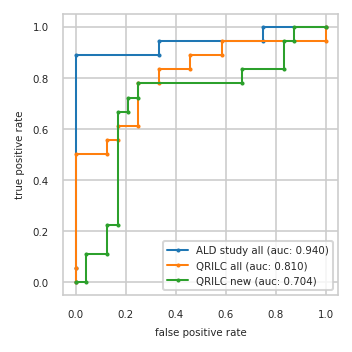

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.889     0.000 0.500     0.042 0.111
3          0.333 0.889     0.125 0.500     0.125 0.111
4          0.333 0.944     0.125 0.556     0.125 0.222
5          0.750 0.944     0.167 0.556     0.167 0.222
6          0.750 1.000     0.167 0.611     0.167 0.667
7          1.000 1.000     0.250 0.611     0.208 0.667
8            NaN   NaN     0.250 0.778     0.208 0.722
9            NaN   NaN     0.333 0.778     0.250 0.722
10           NaN   NaN     0.333 0.833     0.250 0.778
11           NaN   NaN     0.458 0.833     0.667 0.778
12           NaN   NaN     0.458 0.889     0.667 0.833
13           NaN   NaN     0.583 0.889     0.833 0.833
14           NaN   NaN     0.583 0.944     0.833 0.944
15           NaN   NaN     1.000 0.944     0.875 0.944
16           NaN   NaN     1.000 1.000     0.875 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,P09417,P04114,None
2,J3KNE3;P68402,A0A0G2JRN3,None
3,P61981,P61981,None
4,P04075,P10636-2;P10636-6,None
5,P14174,P14174,None
6,P08294,P04075,None
7,Q9Y2T3;Q9Y2T3-3,P63104,None
8,P00338;P00338-3,P15151-2,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


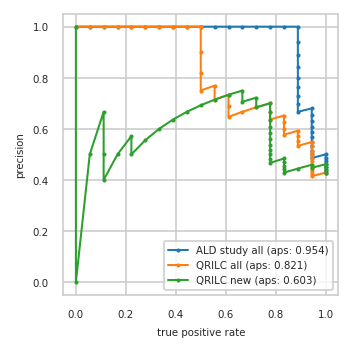

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.415 0.944     0.439 1.000
2          0.450 1.000     0.425 0.944     0.450 1.000
3          0.462 1.000     0.436 0.944     0.462 1.000
4          0.474 1.000     0.447 0.944     0.447 0.944
5          0.486 1.000     0.459 0.944     0.459 0.944
6          0.500 1.000     0.472 0.944     0.444 0.889
7          0.486 0.944     0.486 0.944     0.429 0.833
8          0.500 0.944     0.500 0.944     0.441 0.833
9          0.515 0.944     0.515 0.944     0.455 0.833
10         0.531 0.944     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.533 0.889     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.680 0.944     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.762 0.889     0.667 0.778     0.667 0.778
22         0.800 0.889     0.700 0.778     0.700 0.778
23         0.842 0.889     0.684 0.722     0.684 0.722
24         0.889 0.889     0.667 0.667     0.722 0.722
25         0.941 0.889     0.647 0.611     0.706 0.667
26         1.000 0.889     0.688 0.611     0.750 0.667
27         1.000 0.833     0.733 0.611     0.733 0.611
28         1.000 0.778     0.714 0.556     0.714 0.556
29         1.000 0.722     0.769 0.556     0.692 0.500
30         1.000 0.667     0.750 0.500     0.667 0.444
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


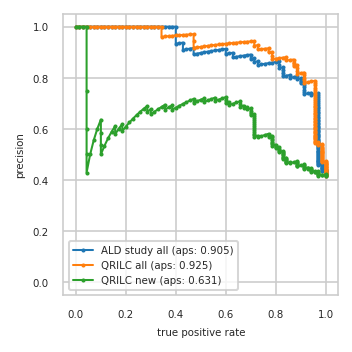

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


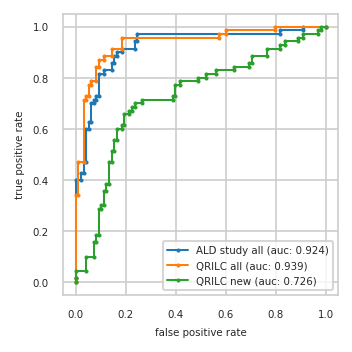

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}